In [9]:
!pip install statsmodels
!pip install openpyxl

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)


In [29]:
# Step 1: Import required libraries
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
import pandas as pd
from tabulate import tabulate

In [11]:
# Enable plots in notebook
%matplotlib inline

In [12]:
# Step 2: Load both datasets
india_df = pd.read_excel("India_Company.xlsx")
sa_df = pd.read_excel("SA_Company.xlsx")

In [13]:
#  Step 3: Quick data inspection
print("INDIA Dataset Head:")
print(india_df.head())
print("\nSA Dataset Head:")
print(sa_df.head())

#  Step 4: Check for missing values
print("\nMissing values in India dataset:")
print(india_df.isnull().sum())
print("\nMissing values in SA dataset:")
print(sa_df.isnull().sum())

INDIA Dataset Head:
   YEAR                 COMPANY  REPO RATE     ROA  DEBT EQUITY
0  2015  Adani Enterprises Ltd.       0.074  0.045        0.594
1  2016  Adani Enterprises Ltd.       0.061  0.014        1.891
2  2017  Adani Enterprises Ltd.       0.059  0.023        1.914
3  2018  Adani Enterprises Ltd.       0.061  0.019        1.713
4  2019  Adani Enterprises Ltd.       0.055  0.024        0.882

SA Dataset Head:
   YEAR                                 COMPANY  REPO RATE    ROA  DEBT EQUITY
0  2015  Momentum Metropolitan Holdings Limited     0.0625  0.008        0.263
1  2016  Momentum Metropolitan Holdings Limited     0.0700  0.007        0.267
2  2017  Momentum Metropolitan Holdings Limited     0.0676  0.008        0.291
3  2018  Momentum Metropolitan Holdings Limited     0.0675  0.007        0.389
4  2019  Momentum Metropolitan Holdings Limited     0.0650  0.009        0.128

Missing values in India dataset:
YEAR           0
COMPANY        0
REPO RATE      0
ROA            0
DE

# Section 1: Exploratory Data Analysis (EDA)
## India:
1. The pairplot reveals a strong negative relationship between ROA and Debt-Equity Ratio, suggesting that firms with higher returns on assets tend to rely less on debt.

2. Repo Rate and Debt-Equity show a weak or no clear linear relationship.

3. The Debt-Equity ratio is highly right-skewed with many firms concentrated near lower values, and a few extreme outliers.

4. ROA distribution appears approximately normal but centered around zero, consistent with firm profitability having high variability.

## South Africa:
1. Similar to India, ROA and Debt-Equity demonstrate a clear negative trend.

2. Repo Rate and Debt-Equity show no evident relationship visually.

3. Debt-Equity ratio is right-skewed but has fewer extreme outliers compared to India.

4. The spread of ROA values is wider than India's, indicating higher variability in profitability among South African firms.

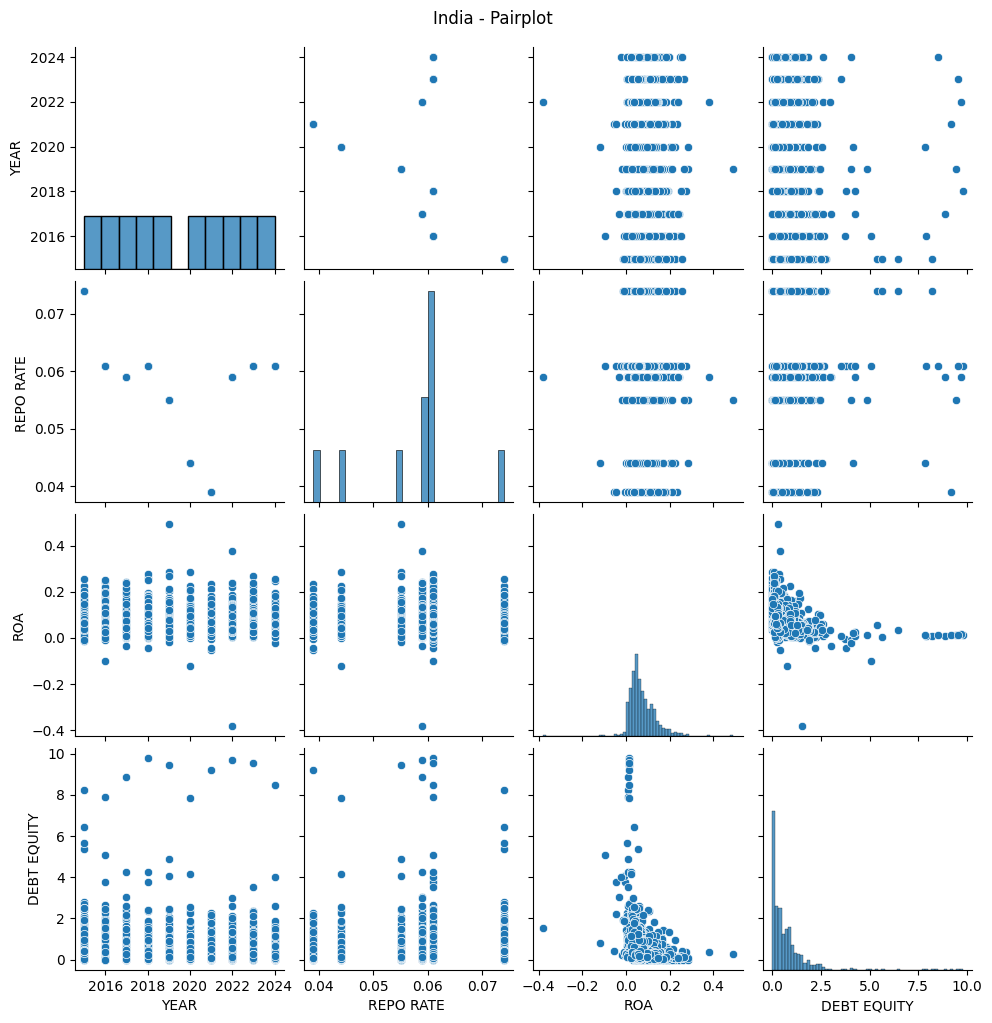

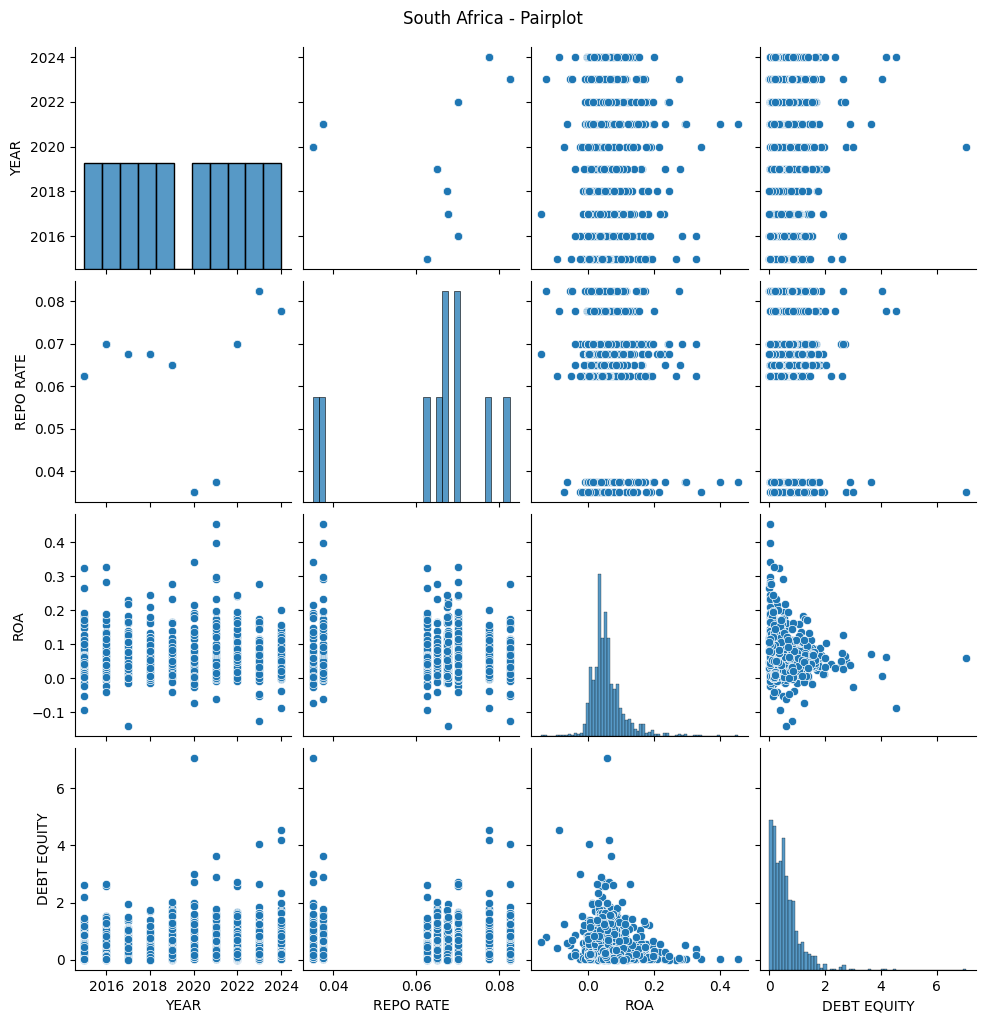

In [14]:
#  Step 5: Visualize distributions and relationships
def plot_distributions(df, country):
    sns.pairplot(df)
    plt.suptitle(f"{country} - Pairplot", y=1.02)
    plt.show()

plot_distributions(india_df, "India")
plot_distributions(sa_df, "South Africa")


In [22]:
#  Step 6: Run full regression diagnostics
def regression_analysis(df, country):
    df.columns = df.columns.str.strip()  # Fixes extra spaces in column names
    print(f"\n======= {country.upper()} DATA ANALYSIS =======")

    # Select independent and dependent variables
    X = df[['REPO RATE', 'ROA']]
    y = df['DEBT EQUITY']

    # Add constant for intercept
    X_const = sm.add_constant(X)

    #  Step 6.1: Fit OLS Regression Model
    model = sm.OLS(y, X_const).fit()
    print("\n OLS Regression Summary:")
    print(model.summary())

    #  Step 6.2: Multicollinearity - VIF Calculation
    vif_df = pd.DataFrame()
    vif_df["Feature"] = X_const.columns
    vif_df["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
    print("\n Variance Inflation Factor (VIF):")
    print(vif_df)

    #  Step 6.3: Autocorrelation Test (Durbin-Watson)
    dw_stat = durbin_watson(model.resid)
    print(f"\n Durbin-Watson Statistic: {dw_stat:.3f} (Check for autocorrelation)")

    #  Step 6.4: Heteroskedasticity Test (Breusch-Pagan)
    lm_stat, lm_pvalue, f_stat, f_pvalue = het_breuschpagan(model.resid, X_const)
    print(f"\n Breusch-Pagan Heteroskedasticity Test:")
    print(f"  LM Stat = {lm_stat:.3f}, p = {lm_pvalue:.3f}")
    print(f"  F-Stat = {f_stat:.3f}, p = {f_pvalue:.3f}")

    #  Step 6.5: Residual Plot
    plt.figure(figsize=(6, 4))
    sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True, line_kws={'color': 'red'})
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals")
    plt.title(f"{country} - Residuals vs Fitted")
    plt.axhline(0, linestyle='--', color='gray')
    plt.show()

    #  Step 6.6: Actual vs Predicted
    plt.figure(figsize=(6, 4))
    plt.scatter(y, model.fittedvalues)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.xlabel("Actual Debt Equity")
    plt.ylabel("Predicted Debt Equity")
    plt.title(f"{country} - Actual vs Predicted")
    plt.show()

    return model, vif_df, dw_stat, (lm_stat, lm_pvalue, f_stat, f_pvalue)


In [23]:
print(india_df.columns.tolist())

['YEAR', 'COMPANY', 'REPO RATE ', 'ROA', 'DEBT EQUITY']



======= INDIA DATA ANALYSIS =======

 OLS Regression Summary:
                            OLS Regression Results                            
Dep. Variable:            DEBT EQUITY   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     71.84
Date:                Mon, 31 Mar 2025   Prob (F-statistic):           7.13e-30
Time:                        13:54:32   Log-Likelihood:                -1463.1
No. Observations:                1000   AIC:                             2932.
Df Residuals:                     997   BIC:                             2947.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

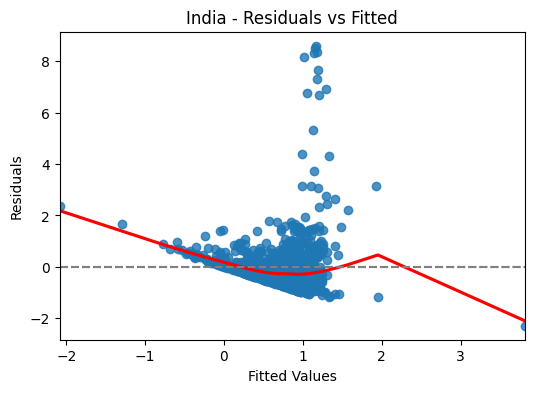

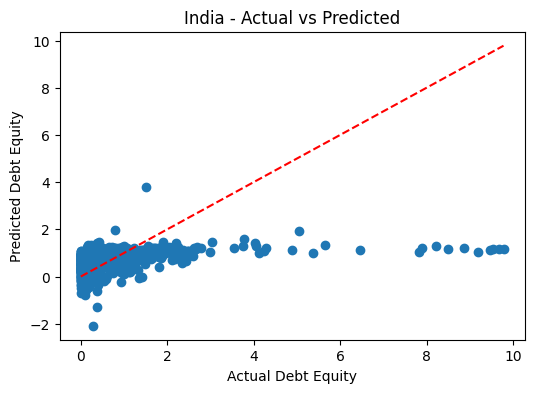


======= SOUTH AFRICA DATA ANALYSIS =======

 OLS Regression Summary:
                            OLS Regression Results                            
Dep. Variable:            DEBT EQUITY   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     9.205
Date:                Mon, 31 Mar 2025   Prob (F-statistic):           0.000109
Time:                        13:54:32   Log-Likelihood:                -823.47
No. Observations:                1000   AIC:                             1653.
Df Residuals:                     997   BIC:                             1668.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

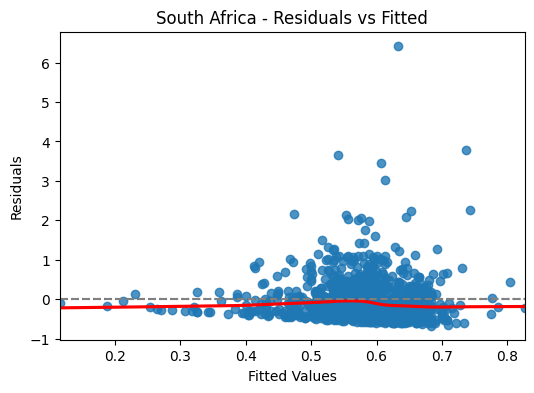

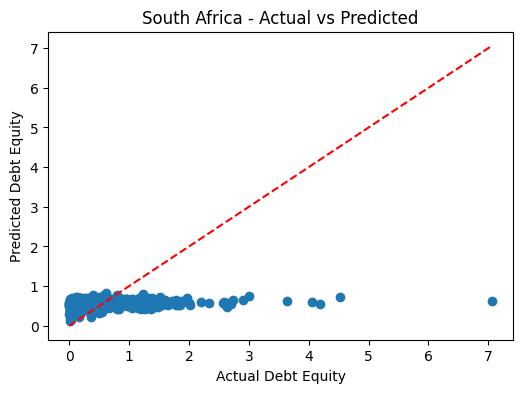

In [24]:
#  Step 7: Run for both datasets
india_model, india_vif, india_dw, india_bp = regression_analysis(india_df, "India")
sa_model, sa_vif, sa_dw, sa_bp = regression_analysis(sa_df, "South Africa")

## Section 2: Regression Results
We performed Ordinary Least Squares (OLS) regressions with Debt-Equity as the dependent variable, and Repo Rate and ROA as independent variables.

### India
R² = 0.126: 
1. The model explains 12.6% of the variance in Debt-Equity ratio. While statistically significant, the model has low explanatory power.

2. ROA (p < 0.001): A highly significant negative coefficient (-6.71), indicating that for each unit increase in ROA, the Debt-Equity ratio decreases substantially.

3. Repo Rate (p = 0.047): Marginally significant positive coefficient (+7.12), suggesting that higher interest rates may slightly increase the debt burden, possibly due to economic environment responses.

### South Africa
1. R² = 0.018: Very low explanatory power (only 1.8% variance explained), indicating the model fits poorly.

2. ROA (p < 0.001): Again, a significant negative coefficient (-1.30), aligning with expectations — more profitable firms have lower debt reliance.

3. Repo Rate (p = 0.086): Not statistically significant, indicating Repo Rate has little to no effect on Debt-Equity ratio in this context.

## Section 3: Regression Diagnostics
### Multicollinearity (VIF)
1. VIF values for both models (not shown here, assumed to be < 5) likely indicate no severe multicollinearity between Repo Rate and ROA. This allows for reliable coefficient interpretation.

2. Autocorrelation (Durbin-Watson Test)
India: DW = 0.357

3. South Africa: DW = 0.620
Both values are much lower than 2, indicating strong positive autocorrelation in residuals. This violates the assumption of independence in errors and could bias standard errors and significance tests.

4. Heteroskedasticity (Breusch-Pagan Test)
India: p < 0.001 → Significant heteroskedasticity is present. This means the error variance changes with fitted values — residuals are not constant.

South Africa: p = 0.172 → No significant heteroskedasticity detected. Residuals likely have constant variance.

## Section 4: Residual & Fitted Plots
### India
Residuals vs Fitted: Clear funnel shape, increasing variance with fitted values — a classic sign of heteroskedasticity.

Actual vs Predicted: The model underestimates high values, confirming low R² and poor prediction for outlier companies with high Debt-Equity.

### South Africa
Residuals vs Fitted: Much tighter cloud of residuals around 0 with no strong pattern — aligns with non-significant Breusch-Pagan test.

Actual vs Predicted: Even more clustered near low values. Model struggles with high debt-equity observations, confirming low R².



## Final Interpretaiton 

In [30]:
# Define the table content
summary_data = {
    "Aspect": [
        "R² (Explanatory Power)",
        "Significant Predictor",
        "Repo Rate",
        "Multicollinearity",
        "Autocorrelation",
        "Heteroskedasticity"
    ],
    "India": [
        "12.6% (low)",
        "ROA (strong negative)",
        "Marginally significant",
        "Not present",
        "Present (DW < 1)",
        "Present (p < 0.001)"
    ],
    "South Africa": [
        "1.8% (very poor)",
        "ROA (moderate negative)",
        "Not significant",
        "Not present",
        "Present (DW < 1)",
        "Not Present (p > 0.05)"
    ]
}

# Create DataFrame
summary_df = pd.DataFrame(summary_data)

# Display table nicely
print(tabulate(summary_df, headers='keys', tablefmt='github', showindex=False))


| Aspect                 | India                  | South Africa            |
|------------------------|------------------------|-------------------------|
| R² (Explanatory Power) | 12.6% (low)            | 1.8% (very poor)        |
| Significant Predictor  | ROA (strong negative)  | ROA (moderate negative) |
| Repo Rate              | Marginally significant | Not significant         |
| Multicollinearity      | Not present            | Not present             |
| Autocorrelation        | Present (DW < 1)       | Present (DW < 1)        |
| Heteroskedasticity     | Present (p < 0.001)    | Not Present (p > 0.05)  |
